# Deep Learning Challenge

## Preamble
The following code downloads and imports all necessary files and modules into the virtual machine of Colab. Please make sure to execute it before solving this exercise.

In [ ]:
import sys, os
if 'google.colab' in sys.modules:
  if os.getcwd() == '/content':
    !git clone 'https://github.com/inb-uni-luebeck/cs5450.git'
    os.chdir('cs5450')

#making sure livelossplot is installed
try:
    import livelossplot
except ModuleNotFoundError:
    import sys
    !{sys.executable} -m pip install livelossplot==0.4.1

## Setup
This exercise can utilize GPU acceleration. If you are using Google Colab you can enable access to a cloud GPU by selecting from the menu above: 

**Runtime > Change runtime type > Hardware accelerator > GPU**

If you are running this notebook on your own machine, GPU acceleration is available if you have an Nvidia GPU and a CUDA-enabled driver installed. Otherwise calculations will run on the CPU.

## Iceberg vs. Ship
In this exercise, we will use deep learning to solve a real-world problem: classifying whether a given grayscale representation of a radar image is a ship or an iceberg. To make things more interesting, this exercise sheet will be carried out as a competition.

Besides the labeled training set of $1000$ images, an unlabeled test set of $604$ images is provided. The dimension of each grayscale image is $30 \times 30$ pixels. An example image of both a ship and an iceberg is given in the figure below.
  
The next cells provide code to get you started. It contains a fully functional implementation of a simple convolutional neural network (CNN). It has a baseline accuracy of $79.50\%$ on the fixed validation set. The architecture of the network is given in table below. Your task is to extend the code, thus optimizing the classification capabilities of the network.

To evaluate the performance of your network, the average **log loss** is used. For a single sample $\vec{x}$ with true binary label $y \in \left\{ 0,1 \right\}$ and an estimated posterior probability $p \in \left[ 0,1 \right]$, the log loss is defined as:
  
  $ E \left( \vec{x} \right) = - \left[ y \log p + \left( 1 - y \right) \log \left( 1 - p \right) \right].$

Your final submission should be a $604$-dimensional vector: the probability that the given sample is an iceberg (label $1$) for each sample of the test set. 

Iceberg | Ship    
- | - 
<img src="https://github.com/inb-uni-luebeck/cs5450/blob/master/data/iceberg.jpg?raw=1" width="300"/> | <img src="https://github.com/inb-uni-luebeck/cs5450/blob/master/data/ship.jpg?raw=1" width="300"/>

| Layer       | Kernel | Stride |    Shape   | #Params |
|-------------|:------:|:------:|:----------:|:-------:|
| Input       |    -   |    -   |      -     |    0    |
| Convolution |  (3,3) |  (1,1) |  (30,30,1) |   160   |
| Pooling     |  (2,2) |  (2,2) | (28,28,16) |    0    |
| Linear      |    -   |    -   |     (2)    |   6274  |


## Ideas to Try
1. [Augment](https://pytorch.org/docs/stable/torchvision/transforms.html) the training data (e.g. mirroring).
2. Make the network deeper (e.g. more convolution and pooling layers)
3. Regularize your network (e.g. with dropout layers).
4. Use cross-validation instead of a fixed train-validation split.
5. Train multiple networks and combine them in an ensemble.
6. Post-process your posterior probabilities (e.g. is log 0 a good idea?) 

In [ ]:
import torch.nn as nn
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import optim
from torch.utils.data import Dataset, DataLoader
from livelossplot import PlotLosses
import torchvision.transforms as transforms
from torchvision import models
from sklearn.model_selection import train_test_split
import json
%matplotlib inline

In [ ]:
def load_data(path):
    X = np.load(path)[...,0,:].astype('float32')
    X -= X.min()
    X = (255.*X/X.max()).astype('uint8')
    X = np.swapaxes(X,0,2)
    return X

In [ ]:
default_aug = test_augmentation = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor()
        ])


class IcebergDataset(Dataset):
    def __init__(self, X, Y=None, augmentation=default_aug, is_test=False):
        if Y is None:
            assert is_test
            
        self.X = X
        self.Y = Y
        
        self.to_tensor = transforms.ToTensor()
        self.augmentation = augmentation
        
        self.is_test = is_test
        
    def __getitem__(self, index):
        x = self.X[index, ...]
        
        x = self.augmentation(x)
        
        if self.is_test:
            return x
        y = self.Y[index]
        y = torch.tensor(y).float()
        
        return x, y
        
    
    def __len__(self):
        return self.X.shape[0]

In [ ]:
#-------------------------------------------------
# ------------Architecture------------------------
#-------------------------------------------------

def make_conv_layer(in_dim, out_dim, kernel_size=3, **kwargs):
    # this "conv_layer" is actually a composition of convolution-layer, relu and batch-normalization
    conv_layer = nn.Sequential()
    
    # NOTE: kwargs could be a dictionary like {'padding':1}
    # you can call the function like e.g.:
    # make_conv_layer(in_dim, out_dim, kernel_size=3, **{'padding':1}) 
    conv_layer.add_module('conv', nn.Conv2d(in_dim, out_dim, kernel_size, **kwargs))
    conv_layer.add_module('relu', nn.ReLU())
    conv_layer.add_module('batch_norm', nn.BatchNorm2d(out_dim))
    
    return conv_layer

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        # in: (b, 1, 30, 30) b= batch_size
        self.conv_0 = make_conv_layer(1, 16, 3)
        # in: (b, 16, 28, 28)
        self.pool_0 = nn.MaxPool2d(2, 2) # kernel -> (2, 2), stride -> (2, 2)
        
        # in: (b, 16, 14, 14) -> will be flattened to (b, 16*14*14) = (b, 3136)
        self.linear = nn.Linear(16*14*14, 1)
        # ouput: (b, 1) 
        
    def forward(self, x):
        # forward is the function that is called when using prediction = model(x)
        
        x = self.conv_0(x)
        x = self.pool_0(x)

        # flatten before fully connected layer 
        x = x.flatten(start_dim=1)
        x = self.linear(x)

        return x[:,0]
    

In [ ]:
def get_optimizer(opt_id, parameters, learning_rate, **kwargs):
    if opt_id == 'SGD':
        optimizer = optim.SGD(parameters,
                              lr=learning_rate,
                              momentum=kwargs.get('momentum', .9),
                              weight_decay=kwargs.get('weight_decay', 0.)
                              )
    elif opt_id == 'Adam':
        optimizer = optim.Adam(
            parameters,
            lr=learning_rate,
            weight_decay=kwargs.get('weight_decay', 0.)
        )
    
    return optimizer
        
def get_scheduler(lr_steps, epochs, optimizer, gamma=.1):
    assert lr_steps < epochs, 'Epochs must be greater than lr_steps'
    step_size = epochs // lr_steps

    scheduler = optim.lr_scheduler.StepLR(
        optimizer, step_size,
        gamma=gamma, last_epoch=-1
    )

    return scheduler


In [ ]:
#-------------------------------------------------
# ------------Hyperparameters---------------------
#-------------------------------------------------

# Data set params: run the Train & Test Data cell for changes here to take place!
batch_size = 32
perc_test_set = .2

learning_rate = 0.0001
weight_decay = 0.0001
num_sched_steps = 2
epochs = 120


In [ ]:
#-------------------------------------------------
# ------------Train & Test Data-------------------
#-------------------------------------------------

# images need to be real uint8 images in [0, 255]

X = load_data('data/train_data.npy')
Y = np.load('data/train_labels.npy')[:,0]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=perc_test_set, random_state=42)

mu = (X_train/255).mean()
sigma = (X_train/255).std()
normalize = transforms.Normalize(mean=[mu,], std=[sigma,])
transform_rgb = transforms.Lambda(lambda image: image.convert('RGB'))
resize = transforms.Lambda(lambda image: image.resize((240,240),resample=1))

train_augmentation = transforms.Compose([
            transforms.ToPILImage(),
            resize,
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation((-45, 45)),
            transform_rgb,
            transforms.ToTensor(),
            normalize
            
        ])


test_augmentation = transforms.Compose([
            transforms.ToPILImage(),
            resize,
            transform_rgb,
            transforms.ToTensor(),
            normalize
        ])


data_loader_train = DataLoader(
    IcebergDataset(X_train,Y_train, train_augmentation),
    batch_size=batch_size,
    num_workers=0,
    shuffle=True
)

data_loader_val = DataLoader(
    IcebergDataset(X_test,Y_test, test_augmentation),
    batch_size=batch_size,
    num_workers=0,
    shuffle=True
)

dataloaders = {
    "train": data_loader_train,
    "validation": data_loader_val
}

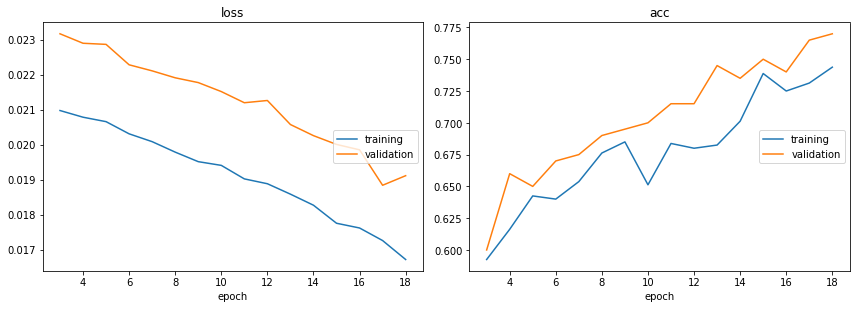

KeyboardInterrupt: ignored

In [ ]:
# train on cuda if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
liveloss = PlotLosses(plot_extrema=False)
 
#-------------------------------------------------
# ------------Setup-----------------------------
#-------------------------------------------------

#model = ConvNet().to(device)
model_ft = models.resnet152(pretrained=True)#densenet201
num_ftrs = model_ft.fc.in_features
#for param in model_ft.parameters():
    #param.requires_grad = False


# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 1)
#model_ft.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3,
#                               bias=False)



model = model_ft.to(device)

optimizer = get_optimizer(
    'SGD', model.parameters(), learning_rate,
    **{'weight_decay':weight_decay, 'momentum':0.9}
)


scheduler = get_scheduler(num_sched_steps, epochs, optimizer)
#scheduler = None

#-------------------------------------------------
# ------------Training-----------------------------
#-------------------------------------------------

loss_fcn = nn.BCEWithLogitsLoss()

for ep in range(epochs):
    logs = {}

    # Run a training epoch, then a validation epoch
    for phase in ['train', 'validation']:
        running_loss = 0.0
        running_corrects = 0.
        counter = 0.
    
        if phase == 'train':
            model.train()
        else:
            model.eval()
        
        for x, label in dataloaders[phase]:

            if phase == 'train':
                prediction = model(x.to(device))
                
                loss = loss_fcn(prediction.float(), label.to(device).unsqueeze(1))
                #loss.requires_grad=True
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
            else:
                with torch.no_grad():
                    prediction = model(x.to(device))
                    loss = loss_fcn(prediction.float(), label.to(device).unsqueeze(1))
                    

            preds = (torch.sigmoid(prediction) >= .5).float()
            counter += float(x.shape[0])
            running_loss += loss.item()
            running_corrects += torch.sum(preds == label.to(device).unsqueeze(1)).item()

            
        prefix = ''
        if phase == 'validation':
            prefix = 'val_'
        
        logs[prefix + 'loss'] = running_loss / counter
        logs[prefix + 'acc'] = running_corrects / counter

    if scheduler is not None:
        scheduler.step()
        
    
    
    
    liveloss.update(logs)
    liveloss.draw()